## Load the important Libraries

In [15]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd # to work with csv files

# matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction import stop_words
print('sklearn stopwords :',len(stop_words.ENGLISH_STOP_WORDS))

from nltk.corpus import stopwords
print('NLTK Stopwords :',len(stopwords.words('english')))

# pre-processing of text
import string
import re

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score

# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics


# import time function from time module to track the training duration
from time import time


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

sklearn stopwords : 318
NLTK Stopwords : 179
/kaggle/input/us-economic-news-articles/US-Economic-News.csv


## Load the US Economic News Data

In [2]:
df = pd.read_csv("/kaggle/input/us-economic-news-articles/US-Economic-News.csv" , encoding = "ISO-8859-1" )
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               8000 non-null   int64  
 1   _golden                8000 non-null   bool   
 2   _unit_state            8000 non-null   object 
 3   _trusted_judgments     8000 non-null   int64  
 4   _last_judgment_at      8000 non-null   object 
 5   positivity             1420 non-null   float64
 6   positivity:confidence  3775 non-null   float64
 7   relevance              8000 non-null   object 
 8   relevance:confidence   8000 non-null   float64
 9   articleid              8000 non-null   object 
 10  date                   8000 non-null   object 
 11  headline               8000 non-null   object 
 12  positivity_gold        0 non-null      float64
 13  relevance_gold         0 non-null      float64
 14  text                   8000 non-null   object 
dtypes: b

## Preprocessing

In [4]:
df["relevance"].value_counts()/df.shape[0] # Class distribution in the dataset

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

There is an imbalance in the data with not relevant being 82% in the dataset. That is, most of the articles are not relevant to US Economy, which makes sense in a real-world scenario, as news articles discuss various topics. We should keep this class imbalance mind when interpreting the classifier performance later. Let us first convert the class labels into binary outcome variables for convenience. 1 for Yes (relevant), and 0 for No (not relevant), and ignore "Not sure".

In [5]:
# convert label to a numerical variable
df1 = df[df.relevance != "not sure"] # removing the data where we don't want relevance="not sure".
print(df1.shape)
df1['relevance'] = df1.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0. 
df2 = df1[["text","relevance"]] # Let us take only the two columns we need.
df2.shape

(7991, 15)


(7991, 2)

### Text Pre-processing
Typical steps involve tokenization, lower casing, removing, stop words, punctuation markers etc, and vectorization. Other processes such as stemming/lemmatization can also be performed. Here, we are performing the following steps: removing br tags, punctuation, numbers, and stopwords. While we are using sklearn's list of stopwords, there are several other stop word lists (e.g., from NLTK) or sometimes, custom stopword lists are needed depending on the task.

In [6]:
Stopwords = stop_words.ENGLISH_STOP_WORDS

def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in Stopwords])
    # remove punctuation and numbers
    return doc

## Build the model
Now we are ready for the modelling. We are going to use algorithms from sklearn package. We will go through the following steps:

1. Split the data into training and test sets (75% train, 25% test)
2. Extract features from the training data using CountVectorizer, which is a bag of words feature implementation. We will use the pre-processing function above in conjunction with Count Vectorizer
3. Transform the test data into the same feature vector as the training data.
4. Train the classifier
5. Evaluate the classifier

In [7]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Step 1: train-test split
X = df2.text # the column text contains textual data to extract features from
y = df2.relevance # this is the column we are learning to predict. 
print(X.shape, y.shape)
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
# random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [8]:
# Step 2-3: Preprocess and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean) # instantiate a vectoriezer
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)# use it to extract features from training data
# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)
# i.e., the dimension of our feature vector is 49753!

(5993, 49753) (1998, 49753)


In [9]:
# Step 3: Train the classifier and predict for test data
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm

CPU times: user 13.8 ms, sys: 993 µs, total: 14.8 ms
Wall time: 13.6 ms


In [10]:
# Step 4: Evaluate the classifier using various measures

# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    
    
# Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

Accuracy:  0.7822822822822822


ROC_AOC_Score:  0.7251117679464362


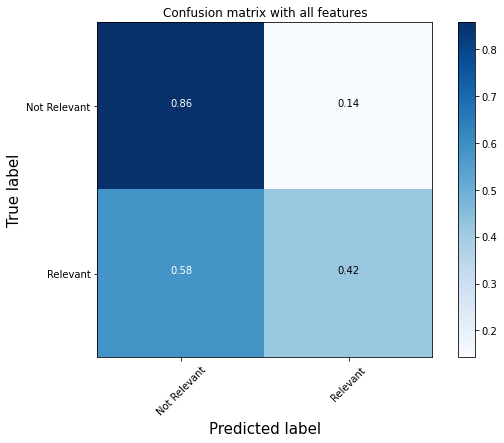

In [11]:
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
# Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

At this point, we can notice that the classifier is doing poorly with identifying relevant articles, while it is doing well with non-relevant ones. Our large feature vector could be creating a lot of noise in the form of very rarely occurring features that are not useful for learning. Let us change the count vectorizer to take a certain number of features as maximum.

CPU times: user 6.65 ms, sys: 43 µs, total: 6.7 ms
Wall time: 6.71 ms
Accuracy:  0.6876876876876877


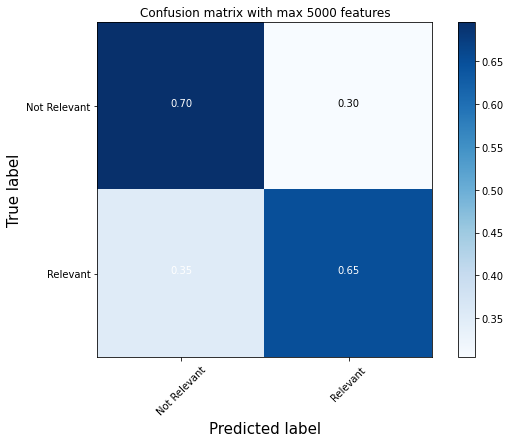

In [12]:
vect = CountVectorizer(preprocessor=clean, max_features=5000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with max 5000 features')

Clearly, the performance on relevance classification got better even though the overall accuracy fell by 10%. Let us try another classification algorithm and see if the performance changes. For this experiment, we have considered logistic regression, with class_weight attribute as "balanced", to address the problem of class imbalance in this dataset.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


Accuracy:  0.7377377377377378
AUC:  0.7251117679464362


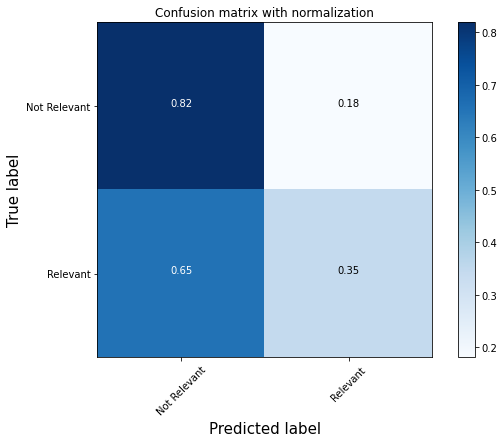

In [13]:
from sklearn.linear_model import LogisticRegression # import

logreg = LogisticRegression(class_weight="balanced") # instantiate a logistic regression model
logreg.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

Let us wrap this notebook by trying with one more classifier, but reducing the feature vector size to 1000.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


Accuracy:  0.6816816816816816
AUC:  0.7251117679464362


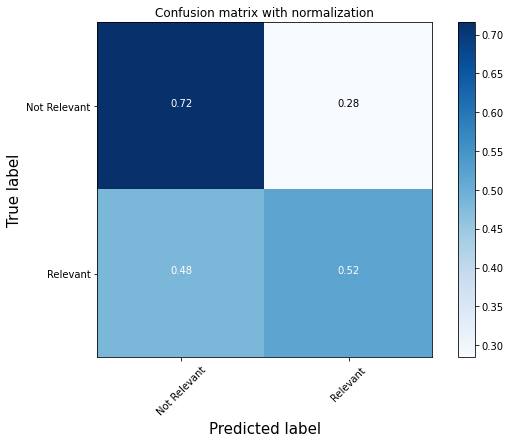

In [14]:
from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor=clean, max_features=1000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced') # instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

So, how do we choose whats the best? If we look at overall accuracy alone, we should be choosing the very first classifier in this notebook. However, that is also doing poorly with identifying "relevant" articles. If we choose purely based on how good it is doing with "relevant" category, we should choose the second one we built. If we choose purely based on how good it is doing with "irrelevant" category, surely, nothing beats not building any classifier and just calling everything irrelevant! So, what to choose as the best among these depends on what we are looking for in our usecase!